In [1]:
import geopandas as gpd
import pandas as pd
from json import load
from requests import Session
from os.path import exists
from re import sub
import warnings

## Preparação: Requisição dos dados da API do Observatório

> Nota: Não é possível solicitar dados de vítima não fatal mais vítima fatal, pois retorna o código `http 500 - Internal Server Error` - Erro no tempo de execução. Será feito duas requisições separadas e inseridas em arquivos diferentes, e então feito a colagem em seguida.

In [2]:
session = Session()
cookie = {'chave':'lgpd'}

if not exists('AcidentesdeTransitoNaoFatal.json'):
    params_nao_fatal = {"data":"[[\"Todos\"],[\"PORTO VELHO\"],[\"VÍTIMA NÃO FATAL\"],[\"Todos\"],[\"1/2019\"],[\"12/2020\"]]",
                        "labels": "[\"Natureza_do_Acidente\",\"Municipio\",\"Consequencia\",\"Via_1\",\"Data_Inicial\",\"Data_Final\"]"}

    req = Session.post(session, url='http://observatorio.sepog.ro.gov.br/TransitoPerfil/GetGeoData', json=params_nao_fatal, cookies=cookie, stream=True)
    with open('AcidentesdeTransitoNaoFatal.json', 'wb') as arq_acidentes:
        arq_acidentes.write(req.content)

if not exists('AcidentesdeTransitoFatal.json'):
    params_fatal = {"data":"[[\"Todos\"],[\"PORTO VELHO\"],[\"VÍTIMA FATAL\"],[\"Todos\"],[\"1/2019\"],[\"12/2020\"]]",
                    "labels": "[\"Natureza_do_Acidente\",\"Municipio\",\"Consequencia\",\"Via_1\",\"Data_Inicial\",\"Data_Final\"]"}

    req = Session.post(session, url='http://observatorio.sepog.ro.gov.br/TransitoPerfil/GetGeoData',json=params_fatal,cookies=cookie, stream=True)
    with open('AcidentesdeTransitoFatal.json', 'wb') as arq_acidentes:
        arq_acidentes.write(req.content)

del session
del cookie

## Primeiro passo: Normalização do JSON
- Será normalizado usando um método do pandas: [json_normalize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html)

Formato padrão do dado:
```
{
    "<tipo de acidente>": {
        "<id>": {
            "LATITUDE": <float>,
            "LONGITUDE": <float>,
            "CONSEQUENCIA": <string>,
            "MUNICIPIO": <string>,
            "VEICULO_1": <string>,
            "VEICULO_2": <string>,
            "DATA_DO_FATO": <datetime>,
            "FROTA": <int>
        }
    }
}
```

In [3]:
with open('AcidentesdeTransitoNaoFatal.json', 'r') as arq_acidentes:
    acidentes = load(arq_acidentes)

    df = pd.DataFrame() # Crio um DataFrame vazio onde irá reunir os dados normalizados

    for tipo_acidente, acidente in acidentes.items(): # Para cada tipo de acidente ...
        for id_, informacoes in acidente.items(): # Para cada item do tipo de acidente...
            informacoes.update({'ID':id_})
            df_items = pd.json_normalize(informacoes)
            df = pd.concat((df, df_items), ignore_index=True)
df

,LATITUDE,LONGITUDE,CONSEQUENCIA,MUNICIPIO,VEICULO_1,VEICULO_2,DATA_DO_FATO,FROTA,ID
0,-8.762072,-63.843155,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,02/01/2019 00:00:00,280860,701762
1,-8.806092,-63.884237,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,20/01/2019 00:00:00,280860,669833
2,-8.738549,-63.862959,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,20/01/2019 00:00:00,280860,733335
3,-8.774956,-63.892546,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,25/01/2019 00:00:00,280860,660121
4,-8.710393,-63.985594,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,27/01/2019 00:00:00,280860,663660
...,...,...,...,...,...,...,...,...,...
9553,-8.800215,-63.795577,VÍTIMA NÃO FATAL,PORTO VELHO,,,12/07/2020 00:00:00,280860,"295089,0"
9554,-8.800483,-63.734232,VÍTIMA NÃO FATAL,PORTO VELHO,,,08/07/2020 00:00:00,280860,"294235,0"
9555,-9.158756,-64.193839,VÍTIMA NÃO FATAL,PORTO VELHO,,,01/07/2020 00:00:00,280860,"292932,0"
9556,-8.766685,-63.884052,VÍTIMA NÃO FATAL,PORTO VELHO,,,01/07/2020 00:00:00,280860,"292934,0"


In [4]:
with open('AcidentesdeTransitoFatal.json', 'r') as arq_acidentes:
    acidentes = load(arq_acidentes)

    # Mesma lógica para este DF
    for tipo_acidente, acidente in acidentes.items():
        for id_, informacoes in acidente.items():
            informacoes.update({'ID':id_})
            df_items = pd.json_normalize(informacoes)
            df = pd.concat((df, df_items), ignore_index=True) # Como o DF já existe, utilizo ele para a inserção.
df

,LATITUDE,LONGITUDE,CONSEQUENCIA,MUNICIPIO,VEICULO_1,VEICULO_2,DATA_DO_FATO,FROTA,ID
0,-8.762072,-63.843155,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,02/01/2019 00:00:00,280860,701762
1,-8.806092,-63.884237,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,20/01/2019 00:00:00,280860,669833
2,-8.738549,-63.862959,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,20/01/2019 00:00:00,280860,733335
3,-8.774956,-63.892546,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,25/01/2019 00:00:00,280860,660121
4,-8.710393,-63.985594,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,27/01/2019 00:00:00,280860,663660
...,...,...,...,...,...,...,...,...,...
9813,-9.347602,-64.644781,VÍTIMA FATAL,PORTO VELHO,MOTO,VEÍCULO ÚNICO,04/02/2020 00:00:00,280860,"267141,0"
9814,-8.773548,-63.821836,VÍTIMA FATAL,PORTO VELHO,MOTO,VEÍCULO ÚNICO,04/05/2020 00:00:00,280860,"1029466,0"
9815,-9.750465,-66.618236,VÍTIMA FATAL,PORTO VELHO,CAMINHÃO,VEÍCULO ÚNICO,28/08/2019 00:00:00,280860,"154501,0"
9816,-8.739714,-63.932140,VÍTIMA FATAL,PORTO VELHO,,,04/10/2020 00:00:00,280860,"312139,0"


## Segundo passo: Limpeza dos dados
- Retirar números após a virgula + a virgula do ID
- Excluir dados sem LATLON
- Tratando dados LATLON para gerar Geometria válida
- Substituir valores vazios das colunas VEICULO_1 e VEICULO_2 com `NÃO INFORMADO`

#### Removendo a virgula mais números após

In [5]:
# Se tiver algum id com virgula mais qualquer outra coisa depois
if df['ID'].str.contains(r'\d,.*?').astype(bool).any():
    dados_incorretos = df['ID'].loc[df['ID'].str.contains(r'\d,.*?')]
    # Para cada id, selec. da vírgula para frente e apague
    dados_corretos = dados_incorretos.apply(lambda id_: sub(r'(?=,).+','', id_))
    # Inserir dados corrigidos no DataFrame
    df.loc[dados_corretos.index, ['ID']] = dados_corretos.to_frame()['ID']

#### Remover dados que estão sem geo

In [6]:
df.drop(df.loc[(df.LATITUDE == "SEM GEO") | (df.LONGITUDE == "SEM GEO")].index, inplace=True)
df

,LATITUDE,LONGITUDE,CONSEQUENCIA,MUNICIPIO,VEICULO_1,VEICULO_2,DATA_DO_FATO,FROTA,ID
0,-8.762072,-63.843155,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,02/01/2019 00:00:00,280860,701762
1,-8.806092,-63.884237,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,20/01/2019 00:00:00,280860,669833
2,-8.738549,-63.862959,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,20/01/2019 00:00:00,280860,733335
3,-8.774956,-63.892546,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,25/01/2019 00:00:00,280860,660121
4,-8.710393,-63.985594,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,27/01/2019 00:00:00,280860,663660
...,...,...,...,...,...,...,...,...,...
9813,-9.347602,-64.644781,VÍTIMA FATAL,PORTO VELHO,MOTO,VEÍCULO ÚNICO,04/02/2020 00:00:00,280860,267141
9814,-8.773548,-63.821836,VÍTIMA FATAL,PORTO VELHO,MOTO,VEÍCULO ÚNICO,04/05/2020 00:00:00,280860,1029466
9815,-9.750465,-66.618236,VÍTIMA FATAL,PORTO VELHO,CAMINHÃO,VEÍCULO ÚNICO,28/08/2019 00:00:00,280860,154501
9816,-8.739714,-63.932140,VÍTIMA FATAL,PORTO VELHO,,,04/10/2020 00:00:00,280860,312139


#### Tratando dados para gerar Geometria válida

##### 1. Procurar dados com caracteres especiais

In [7]:
# Previnir que o LATLON tenha qualquer caracter especial OU 2 pontos OU 2 hífen
Regex_Sem_Carac_Espec = r'[\!\"\#\$%\&\'\(\)\*\+\,\/\:\;\<\=\>\?\@\[\]\^\_\`\{\|\}\~]+|[\.]{2,}|[\-]{2,}'

##### 2. Corrigir esses dados utilizando regex

In [8]:
# Se tiver caracteres ou duplicações de caract. ...
if df['LATITUDE'].str.contains(Regex_Sem_Carac_Espec).astype(bool).any():
    # Pegar linhas que estão com problemas
    dados_incorretos = df['LATITUDE'].loc[df['LATITUDE'].str.contains(Regex_Sem_Carac_Espec)]
    # Consertar erros
    dados_corretos = dados_incorretos.apply(lambda lat: sub(r'[^\-\d\.]|(\.)(?=\.)|(\-)(?=\-)','', lat))
    # Inserir dados corrigidos no DataFrame
    df.loc[dados_corretos.index, ['LATITUDE']] = dados_corretos.to_frame()['LATITUDE']

if df['LONGITUDE'].str.contains(Regex_Sem_Carac_Espec).astype(bool).any():
    dados_incorretos = df['LONGITUDE'].loc[df['LONGITUDE'].str.contains(Regex_Sem_Carac_Espec)]
    dados_corretos = dados_incorretos.apply(lambda lat: sub(r'[^\-\d\.]|(\.)(?=\.)|(\-)(?=\-)','', lat))
    df.loc[dados_corretos.index, ['LONGITUDE']] = dados_corretos.to_frame()['LONGITUDE']

#### Substituir dados vazios com `NÃO INFORMADO`

In [9]:
# Será utilizado o NÃO INFORMADO pois já existe no dado original, irei manter o padrão

# Selecione as tuplas da coluna VEICULO_1 que tenham a condição verdadeira e substitua com 'NÃO INFOMADO'
df.loc[df.VEICULO_1 == '', 'VEICULO_1'] = 'NÃO INFORMADO'
df.loc[df.VEICULO_2 == '', 'VEICULO_2'] = 'NÃO INFORMADO'

### Terceiro Passo: Converção de dados e criar GeoDataFrame
- Mudar tipo de dado da coluna DATA_DO_FATO para `datetime`
- Mudar tipo de dado das colunas LATITUDE E LONGITUDE para `float`
- Mudar tipo de dado da coluna ID para `int`
- Gerar um `GeoDataFrame` válido a partir do `DataFrame`

#### Convertendo coluna DATA_DO_FATO para datetime

In [10]:
df.loc[:,'DATA_DO_FATO'] = pd.to_datetime(df['DATA_DO_FATO'])

#### Convertendo colunas LATITUDE e LONGITUDE para float

In [11]:
df.loc[:, 'LATITUDE'] = pd.to_numeric(df['LATITUDE'], downcast='float')
df.loc[:, 'LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], downcast='float')

#### Convertendo coluna ID para int

In [12]:
df.loc[:,'ID'] = pd.to_numeric(df['ID'], downcast='signed')

#### Verificar se as conversões estão corretas

In [13]:
df.dtypes

LATITUDE               float32
LONGITUDE              float32
CONSEQUENCIA            object
MUNICIPIO               object
VEICULO_1               object
VEICULO_2               object
DATA_DO_FATO    datetime64[ns]
FROTA                   object
ID                       int32
dtype: object

#### Gerar `GeoDataFrame` utilizando o construtor do GeoPandas

In [14]:
# Gerar um GeoDataFrame a partir do DataFrame utilizando as colunas LATLON
#{'init' :'epsg:4674'}
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE), crs=4674)
# Não é mais necessários as colunas...
gdf.drop(['LATITUDE', 'LONGITUDE'], axis=1, inplace=True)
# Não é mais necessário o DataFrame...
del df

gdf.head(20)

,CONSEQUENCIA,MUNICIPIO,VEICULO_1,VEICULO_2,DATA_DO_FATO,FROTA,ID,geometry
0,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,2019-02-01,280860,701762,POINT (-63.84315 -8.76207)
1,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,2019-01-20,280860,669833,POINT (-63.88424 -8.80609)
2,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,2019-01-20,280860,733335,POINT (-63.86296 -8.73855)
3,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,2019-01-25,280860,660121,POINT (-63.89255 -8.77496)
4,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,2019-01-27,280860,663660,POINT (-63.98560 -8.71039)
5,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,2019-01-29,280860,663022,POINT (-63.84447 -8.76868)
6,VÍTIMA NÃO FATAL,PORTO VELHO,VEÍCULO ÚNICO,MOTO,2019-01-31,280860,693030,POINT (-63.84809 -8.75951)
9,VÍTIMA NÃO FATAL,PORTO VELHO,MOTO,VEÍCULO ÚNICO,2020-08-09,280860,1133298,POINT (-63.83331 -8.79986)
11,VÍTIMA NÃO FATAL,PORTO VELHO,MOTO,VEÍCULO ÚNICO,2020-06-10,280860,1136401,POINT (-63.85142 -8.76483)
12,VÍTIMA NÃO FATAL,PORTO VELHO,MOTO,VEÍCULO ÚNICO,2020-11-11,280860,1165199,POINT (-63.82281 -8.77375)


## Quarto Passo: Gerar dados estatísticos (WIP)
### Sumário:
- [Gráfico 1: Cruzamentos mais perigosos](#grafico1)

### Gráfico 1: Cruzamentos mais perigosos

### Coletando as geometrias das ruas de Porto Velho

In [15]:
from osmnx import geometries_from_address

In [16]:
# tags: https://wiki.openstreetmap.org/wiki/Map_features
cidade = geometries_from_address("Porto Velho, Rondonia, Brazil",
                               tags={'place': 'city',
                                     'highway':['trunk', 'secondary', 'residential',
                                                'tertiary', 'service', 'primary',
                                                'primary_link', 'trunk_link', 'unclassified',
                                                'track', 'path', 'living_street',
                                                'footway', 'tertiary_link', 'secondary_link',
                                                'cycleway', 'services', 'proposed', 'pedestrian']}
                               ,dist=20000)

pvh = cidade[['name','geometry','highway','alt_name','oneway','bridge','layer','surface']]
pvh = pvh.to_crs('epsg:4672')
# Pegar localização da cidade de Porto Velho
ponto_pvh = pvh[pvh['name'] == 'Porto Velho']

# Remover point que indica a cidade de pvh
pvh.drop('node', level=0, axis=0)

del cidade

### Seleção dos dados utilizando relações topológicas:
- Será feito um buffer de 0.10 graus (~11km) em volta do ponto que indica o perímetro urbano de Porto Velho.
- Em seguida será feito um filtro dos acidentes que fazem intersecção com o buffer
- Visualizar os dados
- Gerar o dado estatístico para o gráfico: Cruzamentos mais perigosos

#### Visualizando o buffer em relação a cidade

In [17]:
import matplotlib.pyplot as plt

In [18]:
# Gera o buffer
ponto_pvh.insert(loc=0, column='buffer', value=ponto_pvh.buffer(0.10))

/tmp/ipykernel_20262/3346461257.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ponto_pvh.insert(loc=0, column='buffer', value=ponto_pvh.buffer(0.10))


<AxesSubplot:>

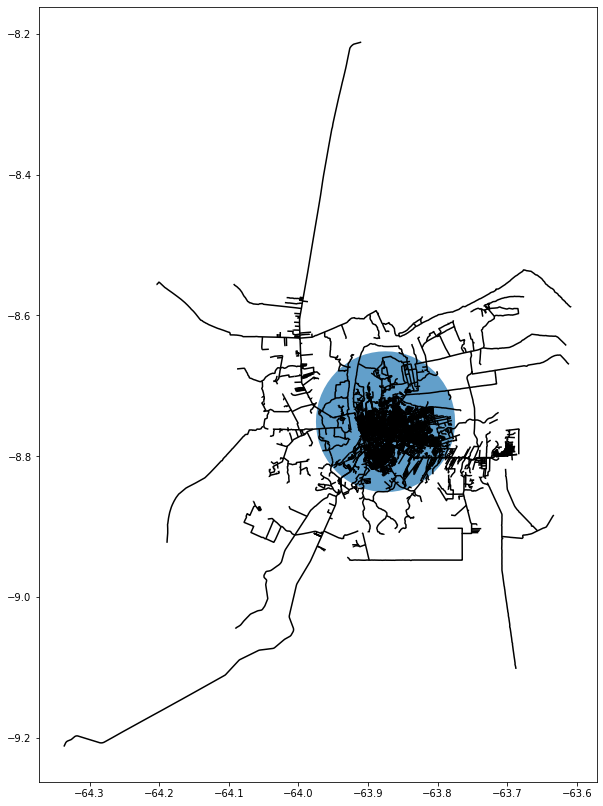

In [19]:
warnings.simplefilter('ignore', category=DeprecationWarning)


# Plota as ruas mais o buffer
fig, ax = plt.subplots(figsize=(10,15))
ponto_pvh['buffer'].plot(ax=ax, alpha=.7)
pvh.plot(ax=ax, facecolor='White', edgecolor='black')

#### Visualizando o dado com as outras camadas

<AxesSubplot:>

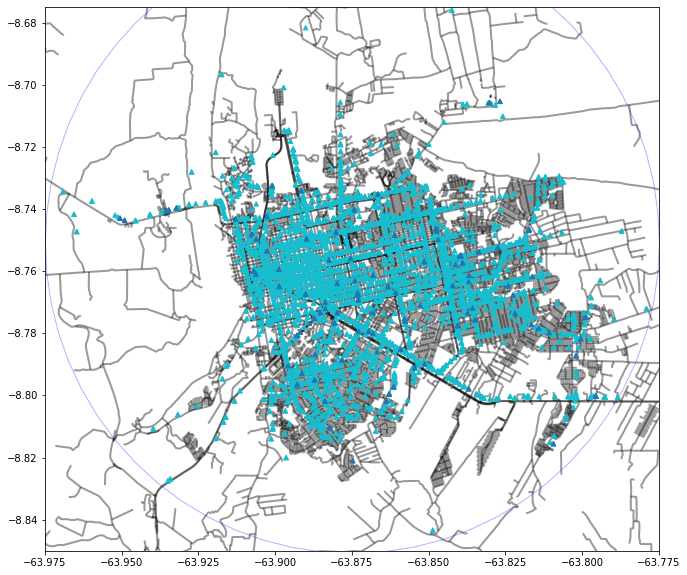

In [20]:
warnings.simplefilter('ignore', category=DeprecationWarning)

fig, ax = plt.subplots(figsize=(15, 10))

# Limite para a imagem não ficar muito grande
ax.set_ylim([-8.850, -8.675])
ax.set_xlim([-63.975, -63.775])

# Plota a cidade mais buffer
pvh.plot(ax=ax, facecolor='None', edgecolor='black', alpha=.4, linewidth=2, zorder=1)
ponto_pvh['buffer'].plot(ax=ax, facecolor='None', edgecolor='blue', alpha=.3, zorder=2)

# Seleciona apenas os acidentes que estão dentro do buffer e plota
gdf.loc[gdf.intersects(ponto_pvh['buffer'].unary_union)].plot(ax=ax,
                                                              markersize = 20,
                                                              column='CONSEQUENCIA',
                                                              marker = "^", zorder=3)

### Gerando o dado estatístico